In [28]:
import ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

s = 0.04
n = 20000
n0 = 5000

sU = 0.02
sV = 0.02
sC = 0.02

In [52]:
a1 = pd.read_csv('dataset2_90_95.csv')
b1 = a1.values[:-1, 1:-1]
a2 = pd.read_csv('dataset2_95_00.csv')
b2 = a2.values[:-1, 1:-1]
a3 = pd.read_csv('dataset2_00_05.csv')
b3 = a3.values[:-1, 1:-1]
a4 = pd.read_csv('dataset2_05_10.csv')
b4 = a4.values[:-1, 1:-1]

In [53]:
def proba_rejet(u, v, W, x, y, Z, T1, T2, T3, T4):
    u,v,W = histogramme(u), histogramme(v), histogramme(W)
    x,y,Z = histogramme(x), histogramme(y), histogramme(Z)
    S1 = np.linalg.norm(T1-ot.emd(u, v, W))**2-np.linalg.norm(T1-ot.emd(x, y, Z))**2
    S2 = np.linalg.norm(T2-ot.emd(u, v, W))**2-np.linalg.norm(T2-ot.emd(x, y, Z))**2
    S3 = np.linalg.norm(T3-ot.emd(u, v, W))**2-np.linalg.norm(T3-ot.emd(x, y, Z))**2
    S4 = np.linalg.norm(T4-ot.emd(u, v, W))**2-np.linalg.norm(T4-ot.emd(x, y, Z))**2
    return 1/(2*s**2)*(S1 + S2 + S3 + S4)

def in_hypercube(u, v, W):

    if any(x < 0 or x > 1 for x in u):
        return False

    if any(x < 0 or x > 1 for x in v):
        return False

    if any(any(x < 0 or x > 1 for x in row) for row in W):
        return False
    
    return True

def histogramme(x):
    # Normaliser la liste pour que la somme soit égale à 1
    somme = np.sum(x)
    histogramme = x / somme
    return histogramme

def MH_gibbs(T1, T2, T3, T4):
    N = len(T1)
    U0 = np.random.random(size=N)
    V0 = np.random.random(size=N)
    C0 = np.random.random(size=(N, N))

    uU = np.log(np.random.random(size=n))
    uV = np.log(np.random.random(size=n))
    uC = np.log(np.random.random(size=n * N))

    vU = np.random.randn(n, N) * sU
    vV = np.random.randn(n, N) * sV
    vC = np.random.randn(n * N, N) * sC

    U = np.zeros((n, N))
    V = np.zeros((n, N))
    C = np.zeros((n * N, N, N))

    U[0] = U0
    V[0] = V0
    C[0] = C0

    SU = 0
    SV = 0
    SC = 0

    acceptance_rate_u = 0
    acceptance_rate_v = 0
    acceptance_rate_C = 0

    for k in range(n-1):
        if k%5000 == 0:
            print(str(k)+" boucles complétées")

        x, y, Z = U[k] + vU[k], V[k], C[k*N]
        if not in_hypercube(x, y, Z):
            U[k+1] = U[k]
        else:
            if uU[k] < proba_rejet(U[k], V[k], C[k*N], x, y, Z, T1, T2, T3, T4):
                U[k+1] = x
                acceptance_rate_u += 1
            else: 
                U[k+1] = U[k]
        UK = U[k+1]
        if k > n0:
            SU += UK

        x, y, Z = UK, V[k] + vV[k], C[k*N]
        if not in_hypercube(x, y, Z):
            V[k+1] = V[k]
        else:
            if uV[k] < proba_rejet(UK, V[k], C[k*N], x, y, Z, T1, T2, T3, T4):
                V[k+1] = y
                acceptance_rate_v += 1
            else: 
                V[k+1] = V[k]
        VK = V[k+1]
        if k > n0:
            SV += VK

        for i in range(N):
            x, y, Z = UK, VK, np.copy(C[k*N+i])
            Z[i] += vC[k*N+i]
            if not in_hypercube(x, y, Z):
                C[k*N+i+1] = C[k*N+i]
            else:
                if uC[k*N+i] < proba_rejet(UK, VK, C[k*N+i], x, y, Z, T1, T2, T3, T4):
                    C[k*N+i+1] = Z
                    acceptance_rate_C += 1
                else: 
                    C[k*N+i+1] = C[k*N+i]
        if k > n0:
            SC += C[(k+1)*N]

    SU /= (n - n0)
    SV /= (n - n0)
    SC /= (n - n0)

    acceptance_rate_u /= n
    acceptance_rate_v /= n
    acceptance_rate_C /= (n * N)
    return U, V, C, acceptance_rate_u, acceptance_rate_v, acceptance_rate_C, SU, SV, SC

In [54]:
np.random.seed(123)

u = np.random.random(5)
v = np.random.random(5)
W = np.random.uniform(size=(5, 5))

u, v, W = histogramme(u), histogramme(v), histogramme(W)

T = ot.emd(u, v, W)

T1 = T + np.random.randn(5, 5) * s
T2 = T + np.random.randn(5, 5) * s
T3 = T + np.random.randn(5, 5) * s
T4 = T + np.random.randn(5, 5) * s

# Simulation
start_time = time.time()
U, V, C, acceptance_rate_u, acceptance_rate_v, acceptance_rate_C, SU, SV, SC = MH_gibbs(T1, T2, T3, T4)
print("--- %s seconds ---" % (time.time() - start_time))

0 boucles complétées
5000 boucles complétées
10000 boucles complétées
15000 boucles complétées
--- 139.98370027542114 seconds ---


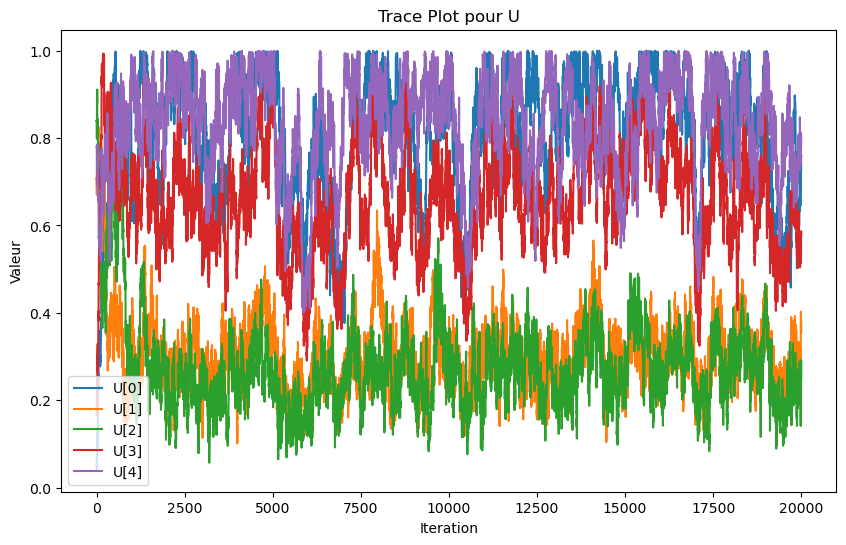

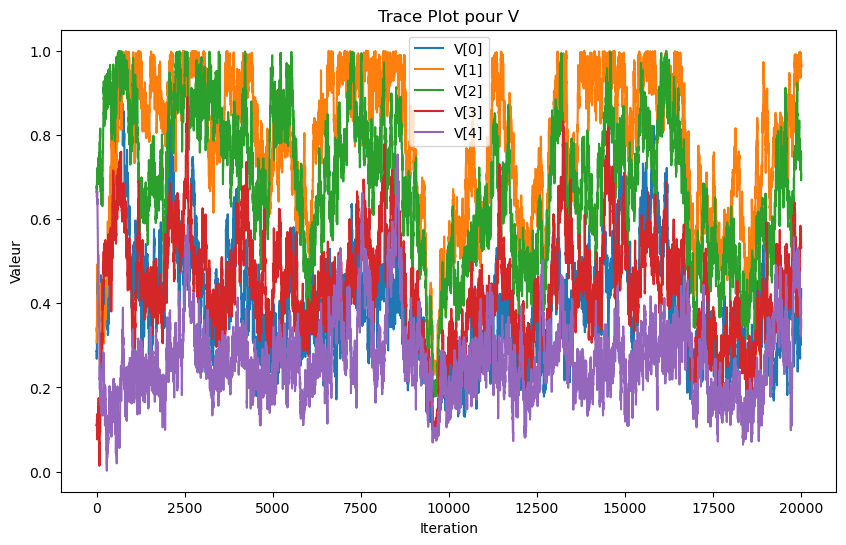

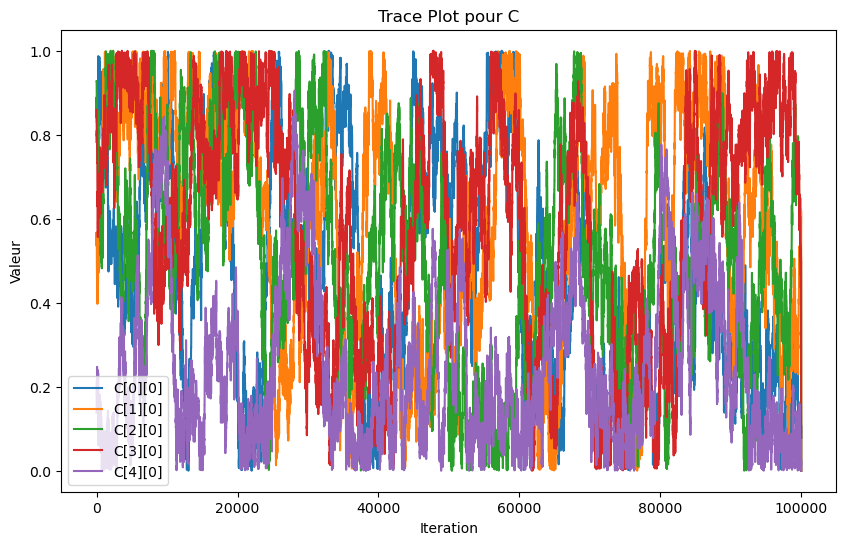

Taux d'acceptation pour U : 0.65225
Taux d'acceptation pour V : 0.63335
Taux d'acceptation pour C : 0.85609


In [55]:
# Trace plot pour U
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(U[:, i], label=f"U[{i}]")
plt.title("Trace Plot pour U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# Trace plot pour V
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(V[:, i], label=f"V[{i}]")
plt.title("Trace Plot pour V")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(C[0])):
    plt.plot(C[:, i, 0], label=f"C[{i}][{0}]")
plt.title("Trace Plot pour C")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()


print(f"Taux d'acceptation pour U : {acceptance_rate_u}")
print(f"Taux d'acceptation pour V : {acceptance_rate_v}")
print(f"Taux d'acceptation pour C : {acceptance_rate_C}")

In [56]:
u0 = SU/np.sum(SU)
print(u, u0)

[0.28080675 0.11536743 0.09146337 0.2222825  0.29007995] [0.28457146 0.10369656 0.09228911 0.22957231 0.28987057]


In [57]:
v0 = SV/np.sum(SV)
print(v, v0)

[0.14285692 0.3311435  0.23122471 0.162381   0.13239387] [0.14718694 0.31016243 0.26155485 0.17064418 0.1104516 ]


In [58]:
print(W)

[[0.03014702 0.06404454 0.03852708 0.0052425  0.03496683]
 [0.06483039 0.01603128 0.01541284 0.04669498 0.04671924]
 [0.05572997 0.07461969 0.06364094 0.05367634 0.06346419]
 [0.02837084 0.0317819  0.02005215 0.02580178 0.05542911]
 [0.00809111 0.03809917 0.03784983 0.04336856 0.03740774]]


In [59]:
W0 = SC/np.sum(SC)
print(W0)

[[0.03699877 0.06243841 0.04193791 0.0217604  0.01767811]
 [0.04433645 0.02037647 0.05129691 0.05152455 0.03983796]
 [0.03692875 0.02240589 0.05002193 0.04223201 0.04350361]
 [0.0435439  0.0542182  0.01436388 0.04928762 0.04924494]
 [0.0208957  0.04563875 0.04551213 0.05360877 0.04040796]]


In [60]:
print(T)

[[0.         0.         0.         0.162381   0.11842575]
 [0.         0.11536743 0.         0.         0.        ]
 [0.         0.06855304 0.00894221 0.         0.01396812]
 [0.         0.         0.2222825  0.         0.        ]
 [0.14285692 0.14722303 0.         0.         0.        ]]


In [61]:
ot.emd(u0, v0, W0)

array([[0.        , 0.        , 0.00347568, 0.17064418, 0.1104516 ],
       [0.        , 0.10369656, 0.        , 0.        , 0.        ],
       [0.        , 0.09228911, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.22957231, 0.        , 0.        ],
       [0.14718694, 0.11417677, 0.02850686, 0.        , 0.        ]])